<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/LPPL%20Model%20(Crash%20timing%20prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# LPPL 함수 정의
def lppl_model(t, A, B, C, tc, beta, omega, phi):
    return A + B * np.power(tc - t, beta) + C * np.power(tc - t, beta) * np.cos(omega * np.log(tc - t) + phi)

# 주식 데이터를 가져오는 함수 (예: S&P 500 인덱스)
def get_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Log_Price'] = np.log(df['Close'])
    return df

# 초기 추정치를 계산하는 함수
def calculate_initial_guesses(df):
    log_prices = df['Log_Price']

    # A: 주가의 평균 로그 값
    A = np.mean(log_prices)

    # B: 최근 상승률 (로그 변화율)
    B = (log_prices.iloc[-1] - log_prices.iloc[-30]) / 30

    # C: 주가의 변동성 (로그 가격의 표준편차)
    C = np.std(log_prices)

    # tc: 데이터의 마지막 시점보다 훨씬 뒤의 시점 (안정성을 위해 더 먼 미래로 설정)
    t_last = len(df)  # 데이터의 마지막 인덱스
    tc = t_last + 150  # 마지막 데이터보다 150일 뒤로 설정

    # beta: 초기 값으로 0.5 설정
    beta = 0.5

    # omega: 주기적인 진동 빈도 (초기 값으로 8 설정)
    omega = 8

    # phi: 초기 위상 (0으로 설정)
    phi = 0

    return A, B, C, tc, beta, omega, phi

# LPPL 모델을 사용하여 주가 데이터를 적합시키는 함수
def fit_lppl_model(df, initial_guess):
    t = np.arange(0, len(df))
    log_prices = df['Log_Price']

    # 비선형 회귀를 사용하여 매개변수 추정 (경계값 설정)
    bounds = ([-np.inf, -np.inf, -np.inf, t[-1], 0, 0, -np.inf],
              [np.inf, np.inf, np.inf, t[-1] + 200, 1, 20, np.inf])

    params, covariance = curve_fit(lppl_model, t, log_prices, p0=initial_guess, bounds=bounds, maxfev=20000)

    return params

# 결과를 시각화하는 함수
def plot_results(df, params, title):
    t = np.arange(0, len(df))
    predicted_prices = lppl_model(t, *params)

    plt.figure(figsize=(12, 8))
    plt.plot(df['Date'], df['Log_Price'], label='Actual Log Price', color='blue')
    plt.plot(df['Date'], predicted_prices, label='LPPL Model', linestyle='--', color='orange')

    # 충격 예상 시점을 강조
    tc = params[3]
    shock_date = df['Date'].iloc[int(tc)] if tc < len(df) else df['Date'].iloc[-1] + timedelta(days=tc - len(df))
    plt.axvline(shock_date, color='red', linestyle=':', linewidth=2, label=f'Predicted Shock Date: {shock_date.strftime("%Y-%m-%d")}')

    # 충격 강도 계산 및 표시
    shock_strength = abs(params[1])
    plt.title(f'{title}\nPredicted Shock Strength: {shock_strength:.2f}')

    # 하락 강도 추정 표시
    peak_value = np.exp(max(predicted_prices))
    predicted_drop = peak_value * (1 - shock_strength)
    plt.axhline(np.log(predicted_drop), color='purple', linestyle='--', label=f'Predicted Drop: {predicted_drop:.2f}')

    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# 분석 결과를 저장하는 함수
def analyze_period(ticker, start_date, end_date, title):
    df = get_stock_data(ticker, start_date, end_date)
    df.reset_index(inplace=True)
    initial_guess = calculate_initial_guesses(df)
    params = fit_lppl_model(df, initial_guess)
    plot_results(df, params, title)
    return params[3], abs(params[1])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


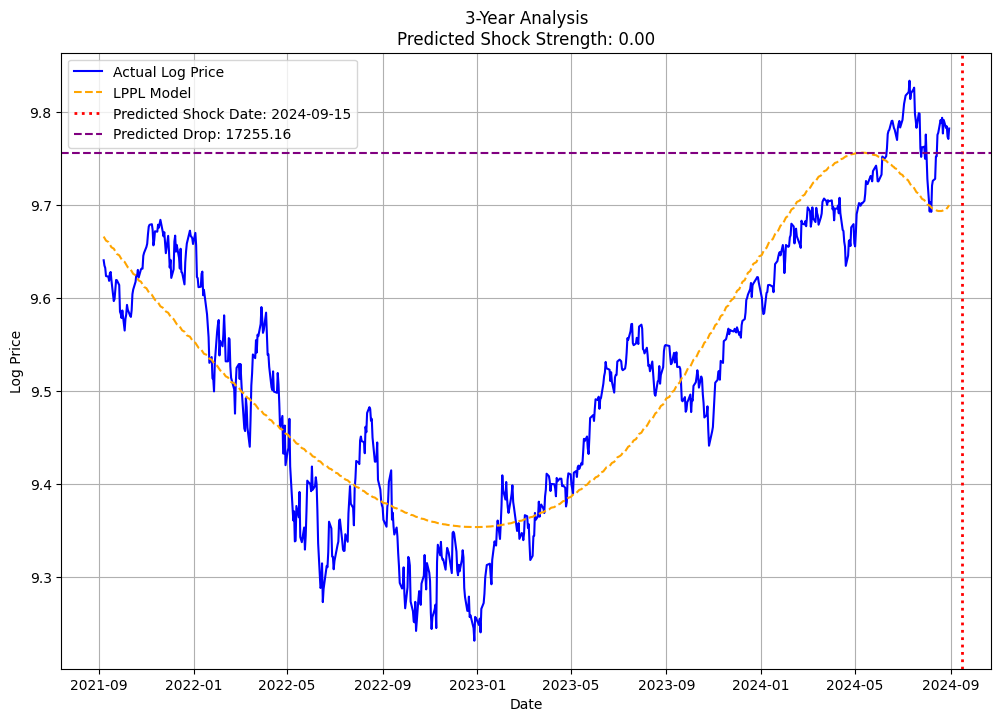

In [33]:
# 3년 분석
ticker = '^IXIC'  # S&P 500 인덱스 심볼
end_date = datetime.today().strftime('%Y-%m-%d')  # 오늘 날짜
start_date_3yr = (datetime.today() - timedelta(days=3*365)).strftime('%Y-%m-%d')  # 3년 전부터

df_3yr = get_stock_data(ticker, start_date_3yr, end_date)
df_3yr.reset_index(inplace=True)  # 인덱스를 재설정하여 'Date' 열을 추가
shock_date_3yr, shock_strength_3yr = analyze_period(ticker, start_date_3yr, end_date, '3-Year Analysis')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


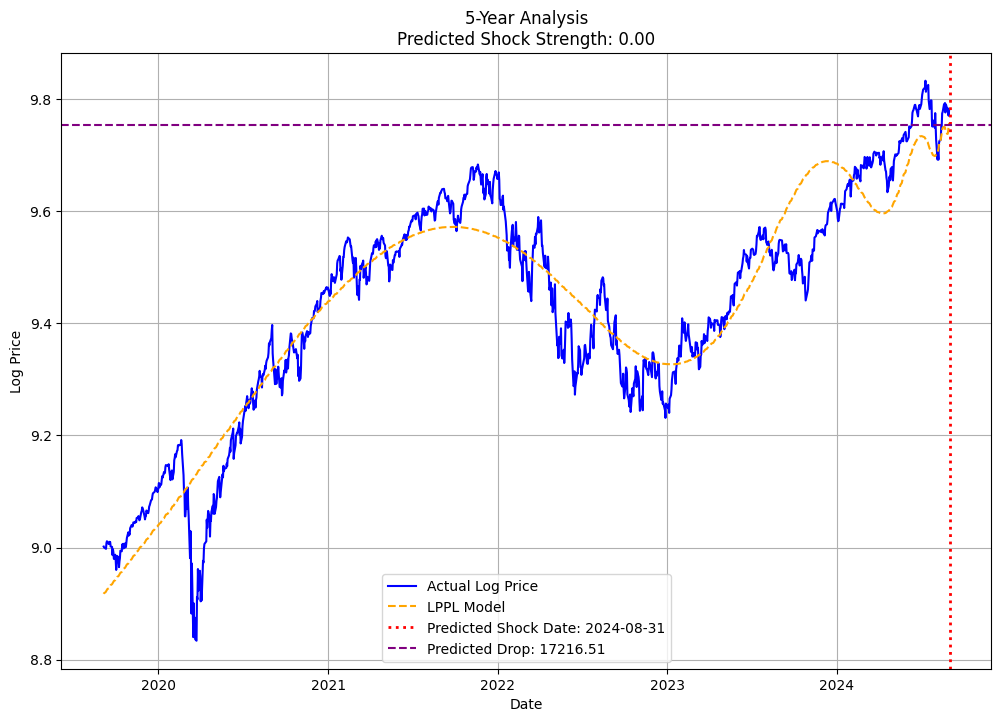

In [34]:
# 5년 분석
start_date_5yr = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')  # 5년 전부터

df_5yr = get_stock_data(ticker, start_date_5yr, end_date)
df_5yr.reset_index(inplace=True)  # 인덱스를 재설정하여 'Date' 열을 추가
shock_date_5yr, shock_strength_5yr = analyze_period(ticker, start_date_5yr, end_date, '5-Year Analysis')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


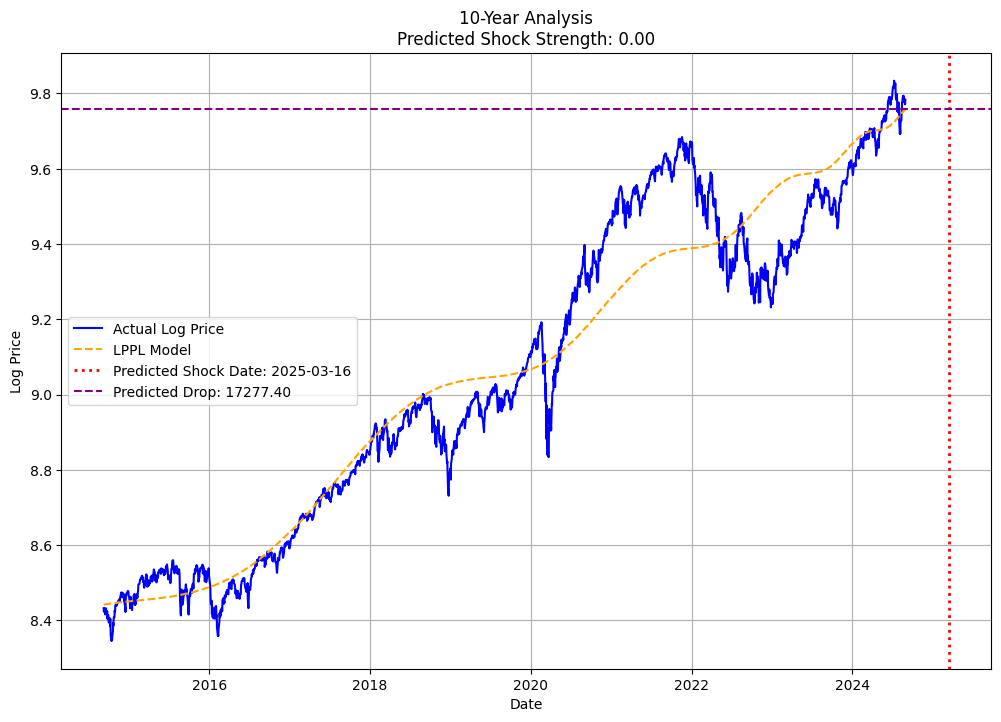

In [35]:
# 10년 분석
start_date_10yr = (datetime.today() - timedelta(days=10*365)).strftime('%Y-%m-%d')  # 10년 전부터

df_10yr = get_stock_data(ticker, start_date_10yr, end_date)
df_10yr.reset_index(inplace=True)  # 인덱스를 재설정하여 'Date' 열을 추가
shock_date_10yr, shock_strength_10yr = analyze_period(ticker, start_date_10yr, end_date, '10-Year Analysis')


In [36]:
# 평균 충격 시점 및 강도 계산
average_tc = np.mean([shock_date_3yr, shock_date_5yr, shock_date_10yr])
average_strength = np.mean([shock_strength_3yr, shock_strength_5yr, shock_strength_10yr])

# 충격 날짜를 3년 데이터프레임 기준으로 변환 (3년, 5년, 10년 분석에서 사용된 데이터가 다를 수 있지만, 충격 시점을 계산하는 데 하나를 기준으로 사용)
average_shock_date = df_3yr['Date'].iloc[int(average_tc)] if average_tc < len(df_3yr) else df_3yr['Date'].iloc[-1] + timedelta(days=average_tc - len(df_3yr))

# 결과 출력
print(f'Average Predicted Shock Date: {average_shock_date.strftime("%Y-%m-%d")}')
print(f'Average Predicted Shock Strength: {average_strength:.2f}')


Average Predicted Shock Date: 2026-12-06
Average Predicted Shock Strength: 0.00
